In [92]:
import cv2
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import xarray as xr
import seaborn as sns
import h5py as hf
from tqdm import tqdm
import itertools 

from base_functions import format_frames

import warnings
warnings.filterwarnings('ignore')


In [185]:
df= pd.read_hdf(r'C:\Users\nlab\obstacle_avoidance\recordings\101322\J20LT\oa\raw_J20LT_101322_oa.h5')


In [110]:
test = df.sample(1)

In [111]:
test.arenaTL_x_cm

5    12.044454
Name: arenaTL_x_cm, dtype: object

In [ ]:
test = df.sample(30)
test = test.reset_index()
plt.subplots(6,5, figsize=(25,21)) 
for ind, row in test.iterrows():
    mid = np.ceil(len(row['obstacleTL_x_cm'])/2)
    mid = np.int(mid)
    
    plt.subplot(6,5,ind +1)
    plt.scatter([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBL_x_cm'], row['arenaBR_x_cm']],
                [row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBL_y_cm'], row['arenaBR_y_cm']],color='red')

    plt.scatter([row['obstacleTL_x_cm_lind'], row['obstacleTR_x_cm_lind'], row['obstacleBL_x_cm_lind'], row['obstacleBR_x_cm_lind']],
                [row['obstacleTL_y_cm_lind'], row['obstacleTR_y_cm_lind'], row['obstacleBL_y_cm_lind'], row['obstacleBR_y_cm_lind']],color='blue')
    
    plt.scatter([row['obstacleTL_x_cm'][mid:], row['obstacleTR_x_cm'][mid:], row['obstacleBL_x_cm'][mid:], row['obstacleBR_x_cm'][mid:]],
                [row['obstacleTL_y_cm'][mid:], row['obstacleTR_y_cm'][mid:], row['obstacleBL_y_cm'][mid:], row['obstacleBR_y_cm'][mid:]],color='green')

    plt.scatter([row['obstacleTL_x_cm'][:mid], row['obstacleTR_x_cm'][:mid], row['obstacleBL_x_cm'][:mid], row['obstacleBR_x_cm'][:mid]],
                [row['obstacleTL_y_cm'][:mid], row['obstacleTR_y_cm'][:mid], row['obstacleBL_y_cm'][:mid], row['obstacleBR_y_cm'][:mid]],color='yellow')


    
    
    plt.scatter(row['obstacle_x_cm_lind'],row['obstacle_y_cm_lind'],color='yellow')

   
    sns.scatterplot(x=row['nose_x_cm'],y=row['nose_y_cm'],hue = row['nose_x_cm'], palette ='magma') 

In [186]:
## calculate arena center
for ind, row in df.iterrows(): 
    xvals_cm = np.stack([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBL_x_cm'], row['arenaBR_x_cm']])
    xvals = np.stack([row['arenaTL_x'], row['arenaTR_x'], row['arenaBL_x'], row['arenaBR_x']])
    df.at[ind,'arena_cen_x_cm'] = np.nanmedian(xvals_cm)
    df.at[ind,'arena_cen_x'] = np.nanmedian(xvals)


    yvals_cm = np.stack([row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBL_y_cm'], row['arenaBR_y_cm']])
    yvals = np.stack([row['arenaTL_y'], row['arenaTR_y'], row['arenaBL_y'], row['arenaBR_y']])
    df.at[ind,'arena_cen_y_cm'] = np.nanmedian(yvals_cm)
    df.at[ind,'arena_cen_y'] = np.nanmedian(yvals)

In [187]:
##  median point at first and last half of trial
obstacle_cols = [col for col in df.columns if 'obstacle' in col]
obstacle_cols = [col for col in obstacle_cols if 'likelihood' not in col]
obstacle_cols = [col for col in obstacle_cols if 'std' not in col]
obstacle_cols = [col for col in obstacle_cols if 'lind' not in col]
for ind, row in df.iterrows():
    # find mid point of obstacle poistion trace
    mid = np.ceil(len(row['obstacleTL_x_cm'])/2)
    mid = np.int(mid)
    
    # calculate median of each corner
    for col in obstacle_cols:
        # first half of trial
        df.at[ind,col+'_fh']= np.nanmedian(row[col][:mid])
        # last half of trial
        df.at[ind,col+'_lh']= np.nanmedian(row[col][mid:])

        

    


    
    

In [188]:
## get median center of obstacle at first and last half 

for ind, row in df.iterrows():
    for half in ['_fh','_lh']:
        xvals = np.stack([row['obstacleTL_x'+ half], row['obstacleTR_x'+ half], row['obstacleBL_x'+ half], row['obstacleBR_x'+ half]])
        xvals_cm = np.stack([row['obstacleTL_x_cm'+ half], row['obstacleTR_x_cm'+ half], row['obstacleBL_x_cm'+ half], row['obstacleBR_x_cm'+ half]])
        df.at[ind,'obstacle_cen_x' + half] = np.nanmedian(xvals)
        df.at[ind,'obstacle_cen_x_cm' + half] = np.nanmedian(xvals_cm)

        yvals = np.stack([row['obstacleTL_y'+ half], row['obstacleTR_y'+ half], row['obstacleBL_y'+ half], row['obstacleBR_y'+ half]])
        yvals_cm = np.stack([row['obstacleTL_y_cm'+ half], row['obstacleTR_y_cm'+ half], row['obstacleBL_y_cm'+ half], row['obstacleBR_y_cm'+ half]])
        df.at[ind,'obstacle_cen_y' + half] = np.nanmedian(yvals)
        df.at[ind,'obstacle_cen_y_cm' + half] = np.nanmedian(yvals_cm)


     
    

In [189]:
# normalize trial postiions to center obstacle center on the center oft the plot. 
#test = df.sample(1)
a_o = ['arena','obstacle']
columns_list = []
for poi in a_o: 
    columns = [col for col in df.columns if poi in col]
    columns_list.append(columns)
columns_list = list(itertools.chain(*columns_list))
columns_list = [col for col in columns_list if '_cm' in col ]
columns_list = [col for col in columns_list if 'lind' not in col ]


for ind, row in df.iterrows():
    x_diff = row['obstacle_cen_x_cm_lh'] - row['arena_cen_x_cm'] 
    y_diff = row['obstacle_cen_y_cm_lh'] - row['arena_cen_y_cm'] 
    ## re center obstacle and area points
    for col in columns_list:
        if 'y' in col:
            if y_diff < 0:
                df.at[ind,'recen_' + col] = row[col] - y_diff
            else:
                df.at[ind,'recen_' + col] = row[col] - y_diff

            
        else:
            if x_diff < 0:
                df.at[ind,'recen_' + col] = row[col] - x_diff
            else:
                df.at[ind,'recen_' + col] = row[col] - x_diff

In [220]:
print(row['arena_cen_x_cm'], row['arena_cen_y_cm'])

36.48702073601545 26.34154840566303


In [190]:
nose_parts= [col for col in df.columns if 'nose' in col]
nose_parts = [col for col in nose_parts if 'likelihood' not in col]
for ind, row in df.iterrows():
    x_diff = row['obstacle_cen_x_cm_lh'] - row['arena_cen_x_cm'] 
    y_diff = row['obstacle_cen_y_cm_lh'] - row['arena_cen_y_cm'] 
    ## re center obstacle and area points
    for col in nose_parts:
        if 'y' in col:
            if y_diff < 0:
                df.at[ind,'recen_' + col] = row[col] - y_diff
            else:
                df.at[ind,'recen_' + col] = row[col] - y_diff

            
        else:
            if x_diff < 0:
                df.at[ind,'recen_' + col] = row[col] - x_diff
            else:
                df.at[ind,'recen_' + col] = row[col] - x_diff

In [152]:
nose_parts= [col for col in df.columns if 'nose' in col]
nose_parts = [col for col in nose_parts if 'likelihood' not in col]

nose_parts

['nose_x', 'nose_y', 'nose_x_cm', 'nose_y_cm', 'recen_nose_x', 'recen_nose_y']

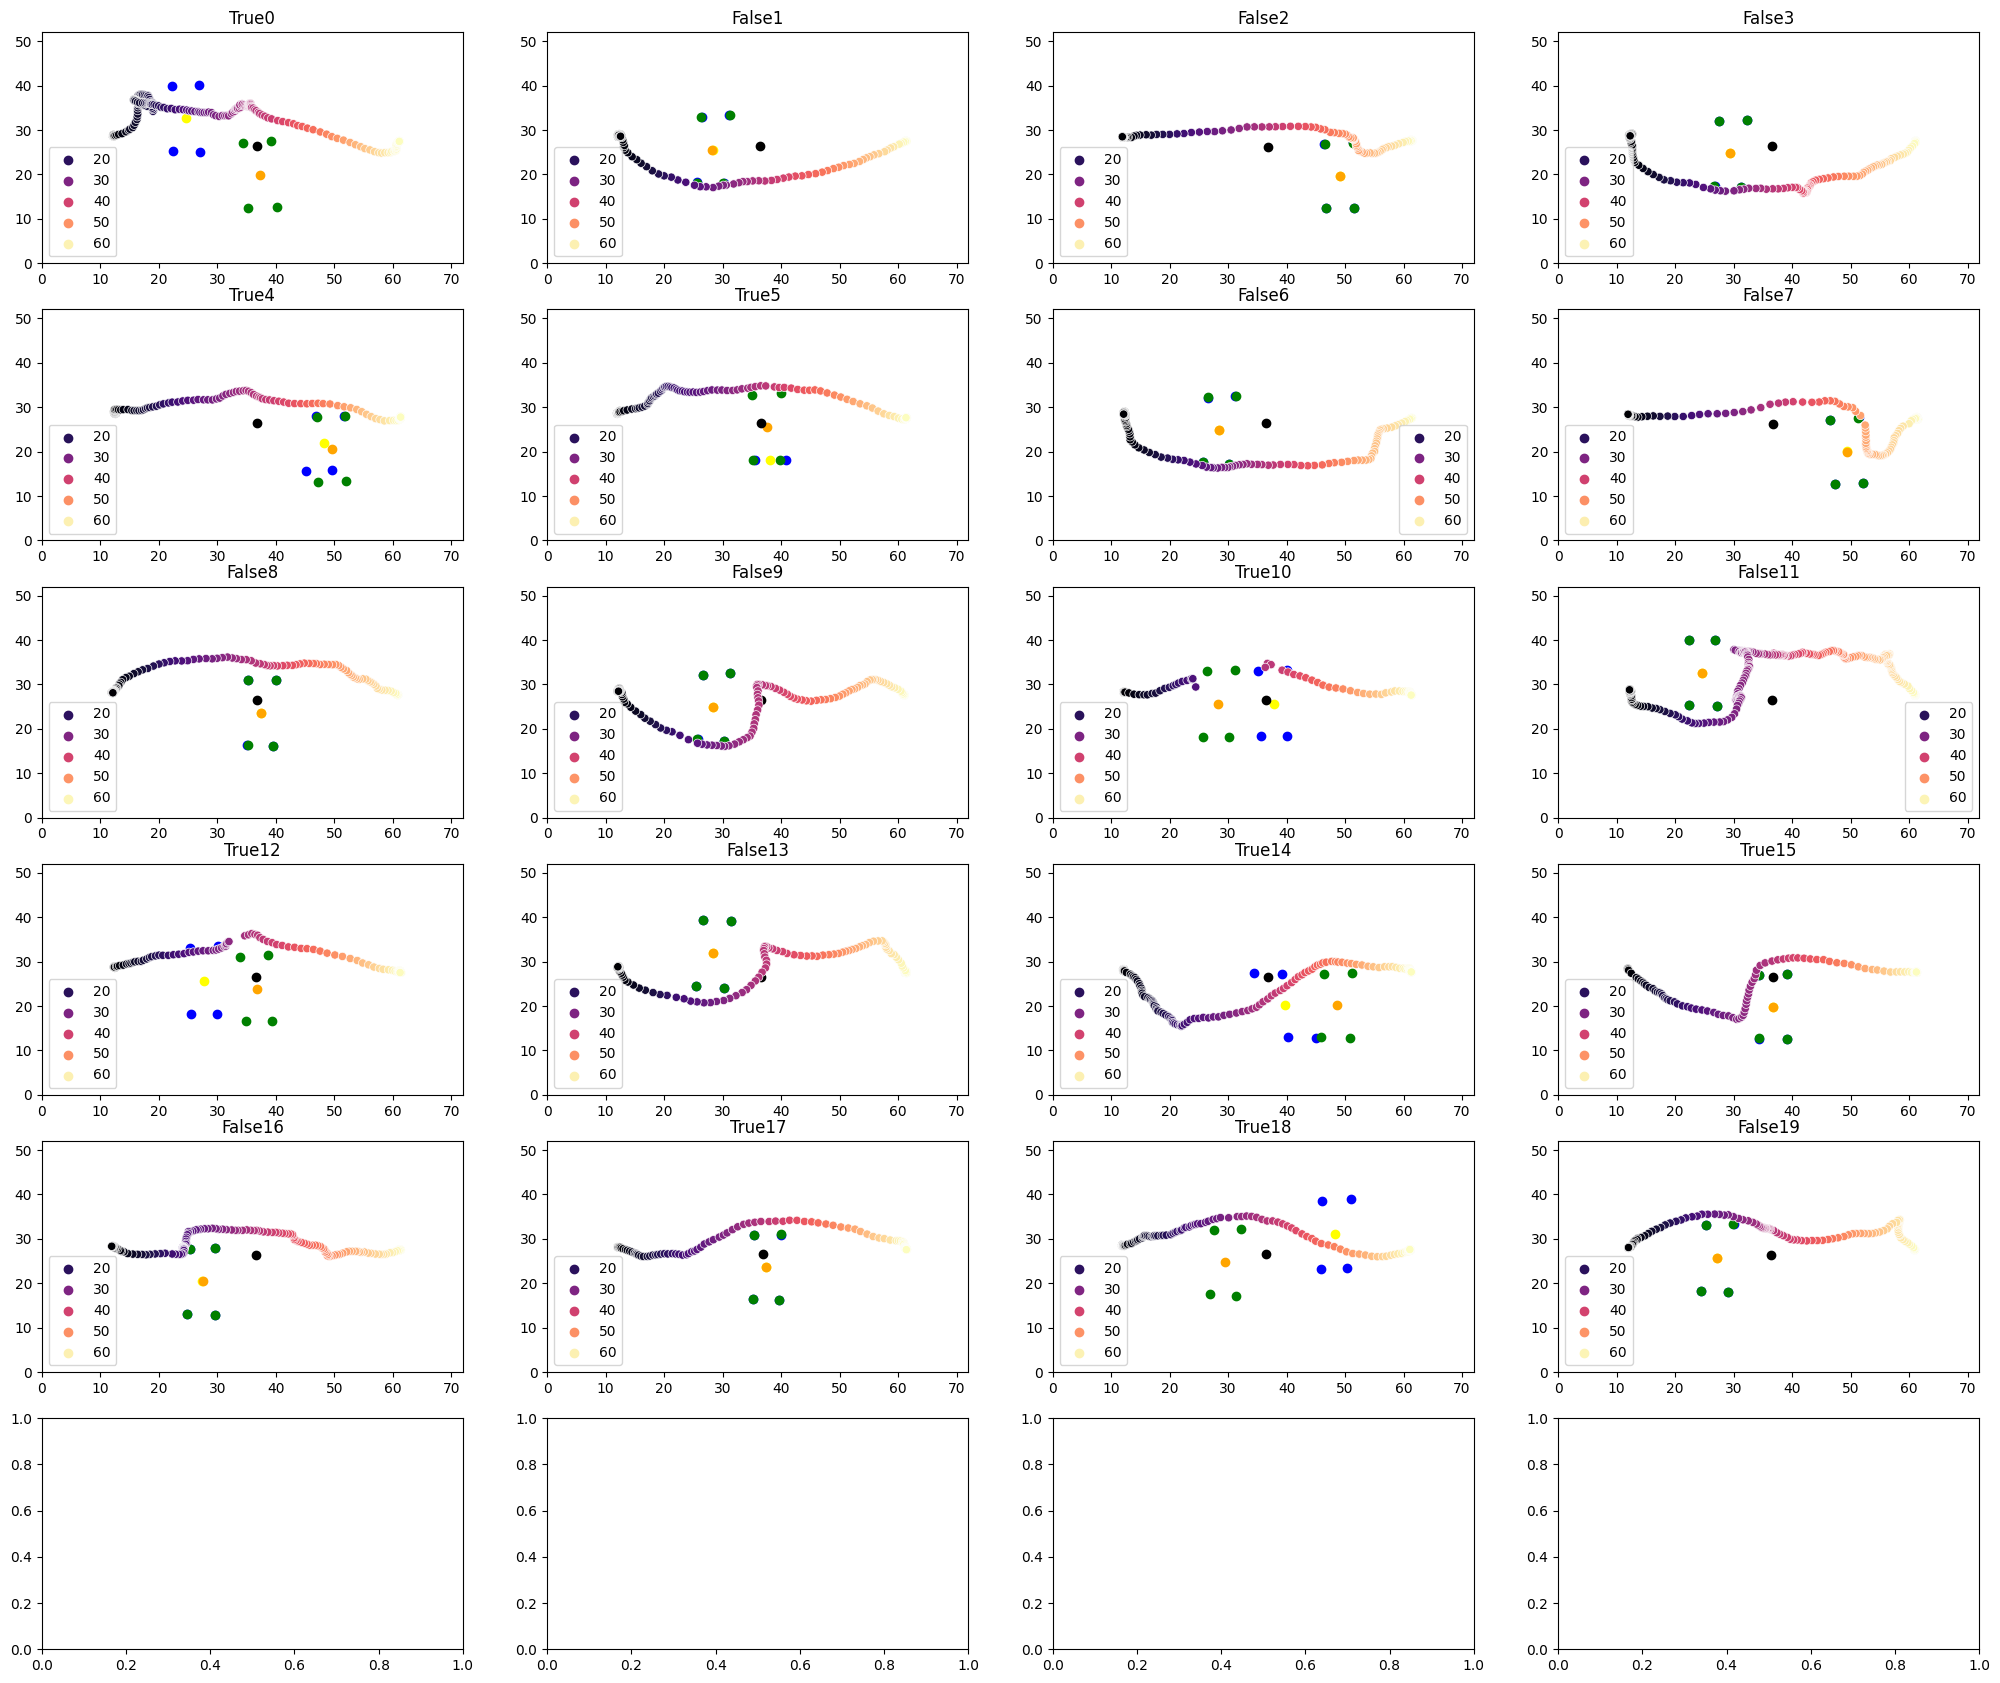

In [222]:
#test = df.sample(20)
#test = test.reset_index()
plt.subplots(6,4, figsize=(25,21))
for ind, row in test.iterrows():
    plt.subplot(6,4,ind +1)
    plt.xlim([0,72])
    plt.ylim([0,52])
    plt.gca().set_title(str(row['odd'])+str(ind))
    #plt.scatter([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBL_x_cm'], row['arenaBR_x_cm']],
                #[row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBL_y_cm'], row['arenaBR_y_cm']],color='red')

    plt.scatter([row['obstacleTL_x_cm_fh'], row['obstacleTR_x_cm_fh'], row['obstacleBL_x_cm_fh'], row['obstacleBR_x_cm_fh']],
                [row['obstacleTL_y_cm_fh'], row['obstacleTR_y_cm_fh'], row['obstacleBL_y_cm_fh'], row['obstacleBR_y_cm_fh']],color='blue')

    plt.scatter([row['obstacleTL_x_cm_lh'], row['obstacleTR_x_cm_lh'], row['obstacleBL_x_cm_lh'], row['obstacleBR_x_cm_lh']],
                [row['obstacleTL_y_cm_lh'], row['obstacleTR_y_cm_lh'], row['obstacleBL_y_cm_lh'], row['obstacleBR_y_cm_lh']],color='green')
    
   
    
    
    plt.scatter(row['obstacle_cen_x_cm_fh'],row['obstacle_cen_y_cm_fh'],color='yellow')
    plt.scatter(row['obstacle_cen_x_cm_lh'],row['obstacle_cen_y_cm_lh'],color='orange')
    plt.scatter(row['arena_cen_x_cm'],row['arena_cen_y_cm'], color ='black')

   
    sns.scatterplot(x=row['nose_x_cm'],y=row['nose_y_cm'],hue = row['nose_x_cm'], palette ='magma') 

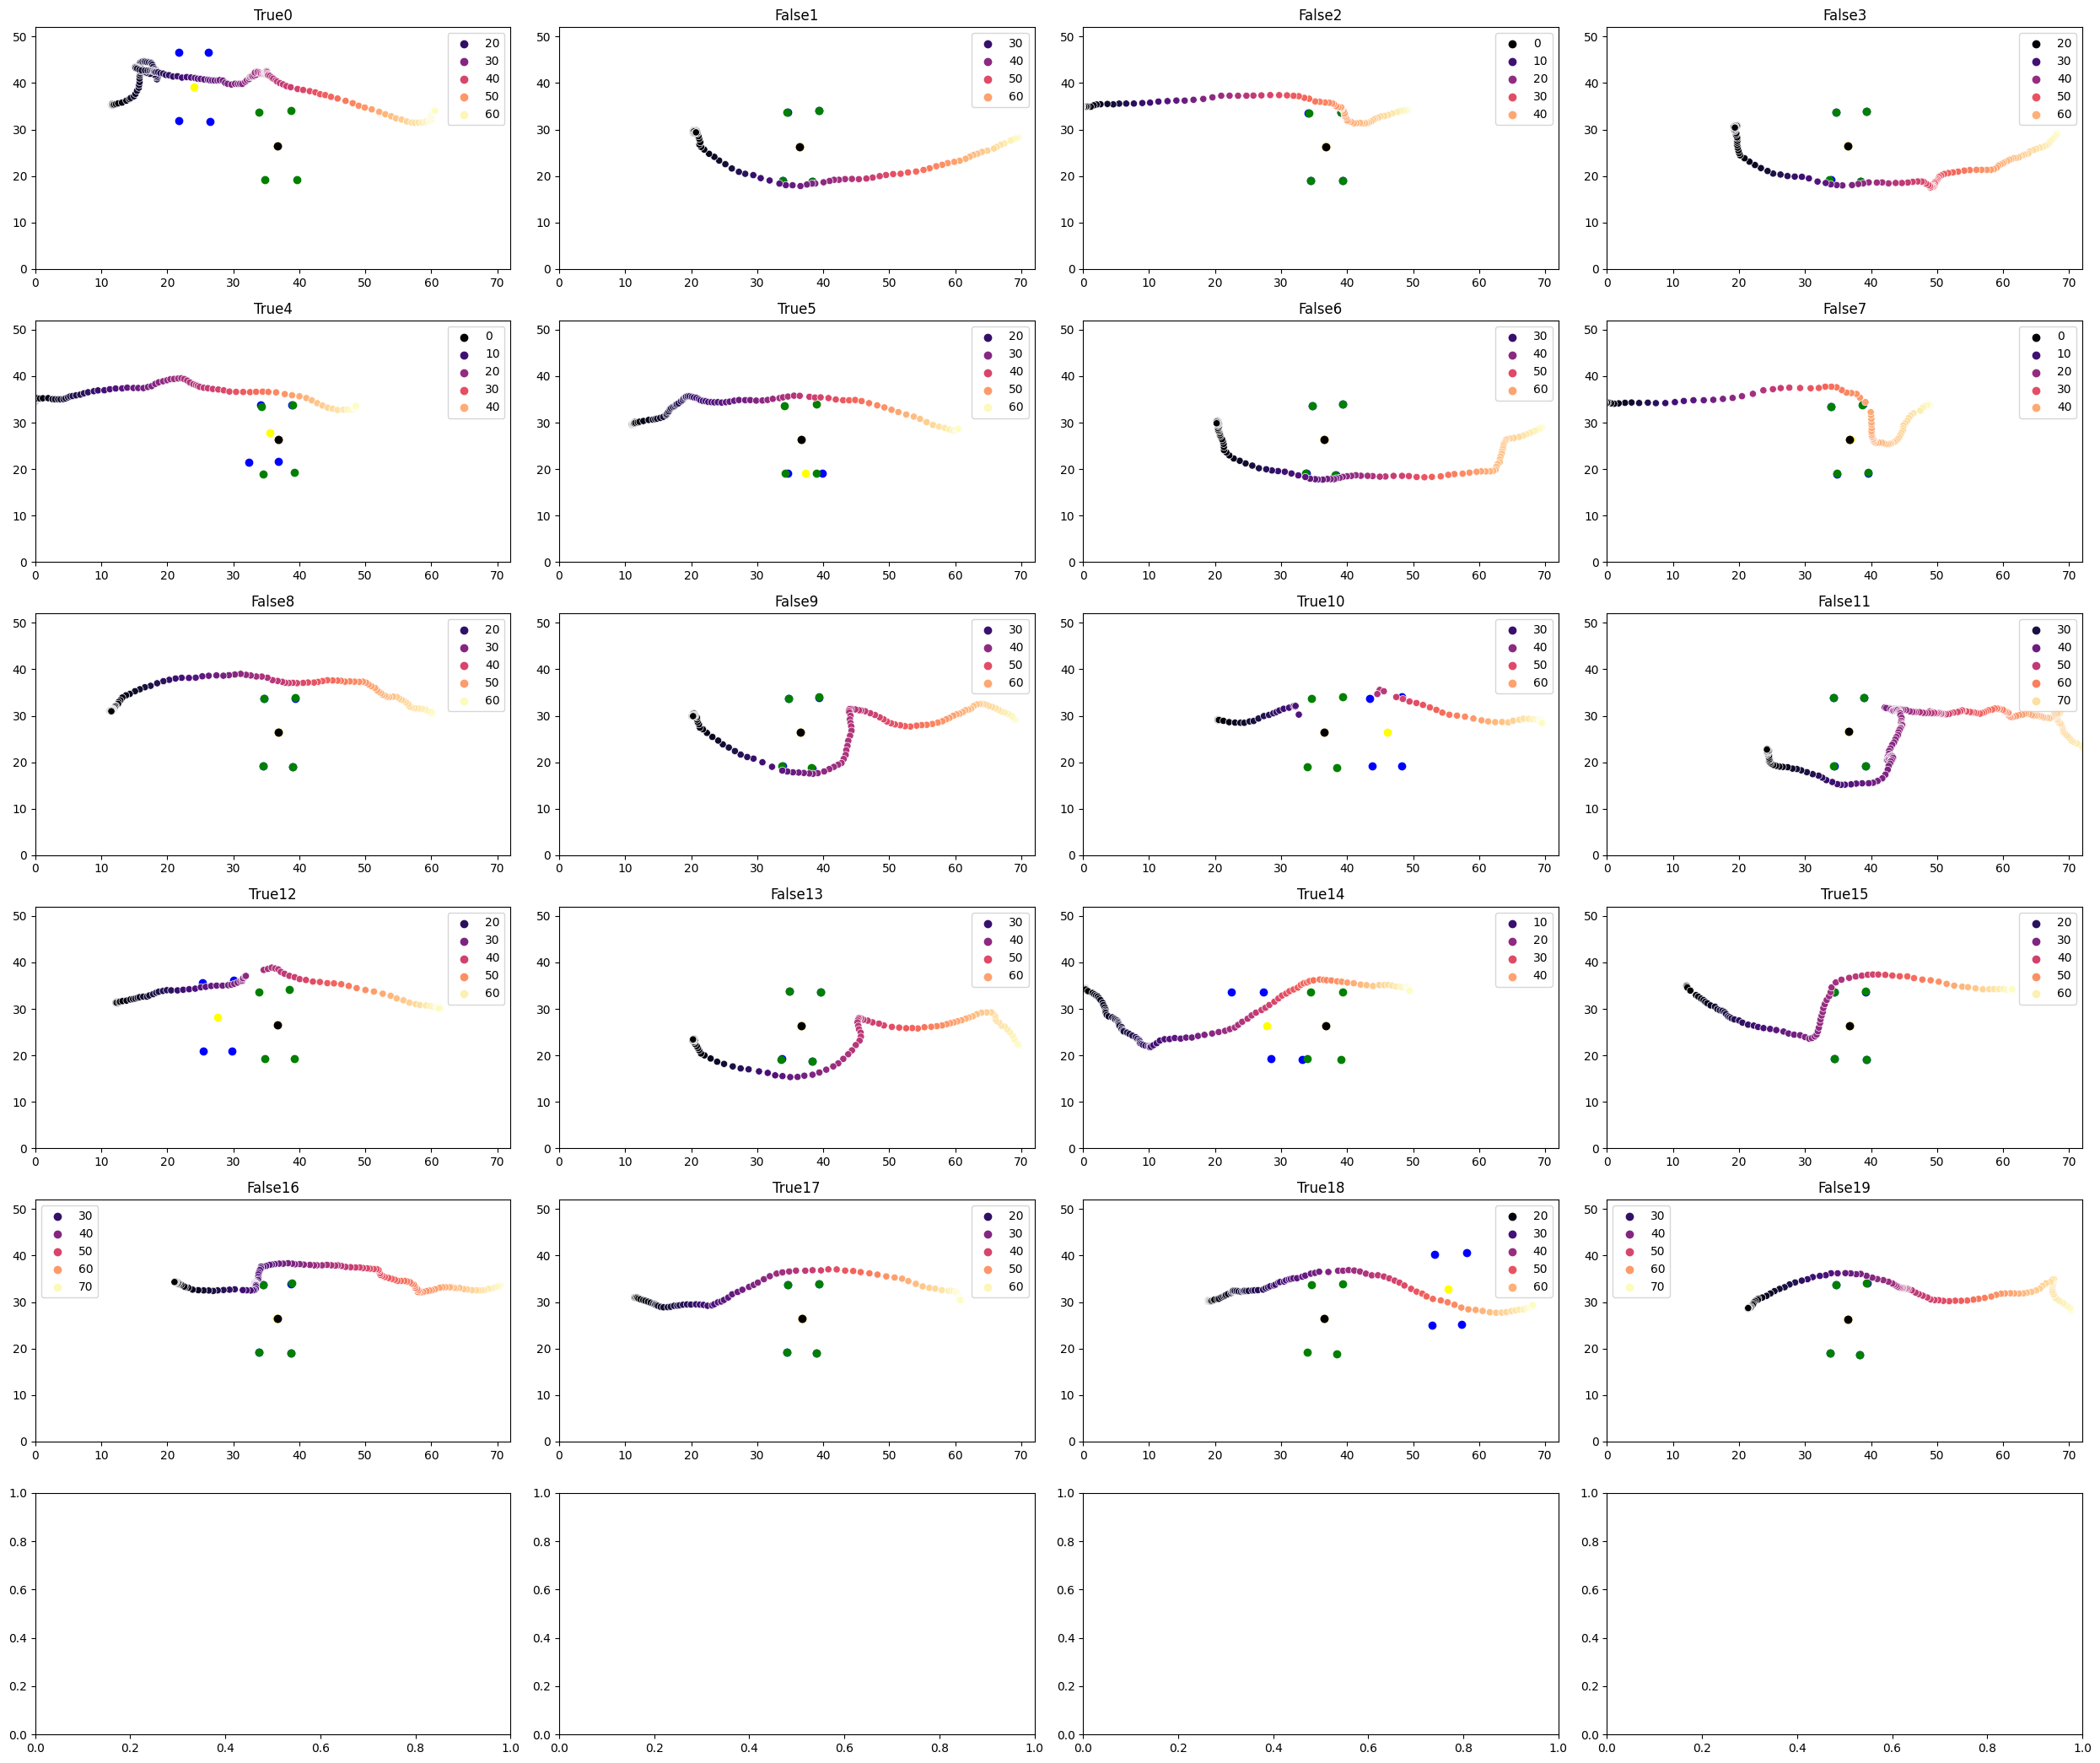

In [223]:
plt.subplots(6,4, figsize=(25,21)) 
for ind, row in test.iterrows():
    plt.subplot(6,4,ind +1)
    plt.xlim([0,72])
    plt.ylim([0,52])
    plt.gca().set_title(str(row['odd'])+str(ind))

    #plt.scatter([row['arenaTL_x_cm'] , row['arenaTR_x_cm'], row['arenaBL_x_cm'], row['arenaBR_x_cm']],
                #[row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBL_y_cm'], row['arenaBR_y_cm']],color='red')

    plt.scatter([row['recen_obstacleTL_x_cm_fh'], row['recen_obstacleTR_x_cm_fh'], row['recen_obstacleBL_x_cm_fh'], row['recen_obstacleBR_x_cm_fh']],
                [row['recen_obstacleTL_y_cm_fh'], row['recen_obstacleTR_y_cm_fh'], row['recen_obstacleBL_y_cm_fh'], row['recen_obstacleBR_y_cm_fh']],color='blue')

    plt.scatter([row['recen_obstacleTL_x_cm_lh'], row['recen_obstacleTR_x_cm_lh'], row['recen_obstacleBL_x_cm_lh'], row['recen_obstacleBR_x_cm_lh']],
                [row['recen_obstacleTL_y_cm_lh'], row['recen_obstacleTR_y_cm_lh'], row['recen_obstacleBL_y_cm_lh'], row['recen_obstacleBR_y_cm_lh']],color='green')
    
    
    plt.scatter(row['recen_obstacle_cen_x_cm_fh'],row['recen_obstacle_cen_y_cm_fh'],color='yellow')
    plt.scatter(row['recen_obstacle_cen_x_cm_lh'],row['recen_obstacle_cen_y_cm_lh'],color='orange')

    plt.scatter(row['arena_cen_x_cm'],row['arena_cen_y_cm'], color ='black')

   
    sns.scatterplot(x=row['recen_nose_x_cm'],y=row['recen_nose_y_cm'],hue = row['recen_nose_x_cm'], palette ='magma')

    plt.tight_layout()            
                

In [122]:
test = df.sample(1)

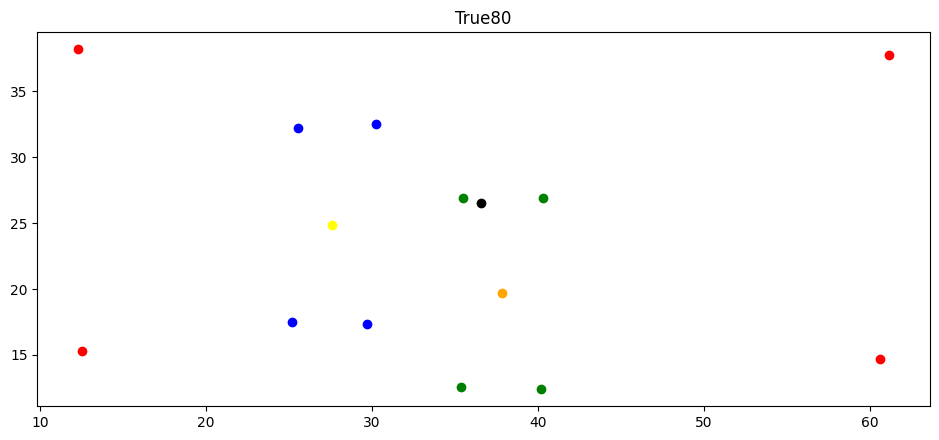

In [132]:
test = df.sample(1)
plt.figure(figsize=(9.5,4.5))
for ind, row in test.iterrows():
    plt.gca().set_title(str(row['odd'])+str(ind))

    plt.scatter([row['arenaTL_x_cm'] , row['arenaTR_x_cm'], row['arenaBL_x_cm'], row['arenaBR_x_cm']],
                [row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBL_y_cm'], row['arenaBR_y_cm']],color='red')

    plt.scatter([row['obstacleTL_x_cm_fh'], row['obstacleTR_x_cm_fh'], row['obstacleBL_x_cm_fh'], row['obstacleBR_x_cm_fh']],
                [row['obstacleTL_y_cm_fh'], row['obstacleTR_y_cm_fh'], row['obstacleBL_y_cm_fh'], row['obstacleBR_y_cm_fh']],color='blue')

    plt.scatter([row['obstacleTL_x_cm_lh'], row['obstacleTR_x_cm_lh'], row['obstacleBL_x_cm_lh'], row['obstacleBR_x_cm_lh']],
                [row['obstacleTL_y_cm_lh'], row['obstacleTR_y_cm_lh'], row['obstacleBL_y_cm_lh'], row['obstacleBR_y_cm_lh']],color='green')
    
    
    plt.scatter(row['obstacle_cen_x_cm_fh'],row['obstacle_cen_y_cm_fh'],color='yellow')
    plt.scatter(row['obstacle_cen_x_cm_lh'],row['obstacle_cen_y_cm_lh'],color='orange')

    plt.scatter(row['arena_cen_x_cm'],row['arena_cen_y_cm'], color ='black')

   
    sns.scatterplot(x=row['nose_x_cm'],y=row['nose_y_cm'],hue = row['nose_x_cm'], palette ='magma')

    plt.tight_layout()            
                

In [226]:
df2 = test.iloc[[1,14]]
df2

,index,first_poke,second_poke,trial_timestamps,trial_vidframes,nose_x,nose_y,nose_likelihood,leftear_x,leftear_y,...,recen_obstacleBL_y_cm_fh,recen_obstacleBL_y_cm_lh,recen_obstacle_cen_x_cm_fh,recen_obstacle_cen_y_cm_fh,recen_obstacle_cen_x_cm_lh,recen_obstacle_cen_y_cm_lh,recen_nose_x,recen_nose_y,recen_nose_x_cm,recen_nose_y_cm
1,85,56838.692710,56841.957363,"[56838.703692, 56838.72064, 56838.73696, 56838...","[[17581, 17582, 17583, 17584, 17585, 17586, 17...","[572.9032592773438, 572.525390625, 572.4139404...","[257.7175598144531, 257.6006774902344, 257.696...","[0.9999972581863403, 0.9999972581863403, 0.999...","[552.477294921875, 551.8084106445312, 551.5223...","[257.8989562988281, 258.1825866699219, 258.578...",...,33.729021,33.757738,36.476532,26.366260,36.435874,26.361333,"[581.0944030180589, 580.7165343657151, 580.605...","[258.50593705337417, 258.3890547291554, 258.48...","[69.50099865204987, 69.46056063415492, 69.4486...","[28.368297486290835, 28.355789199379377, 28.36..."
14,10,56587.504537,56592.399769,"[56587.516928, 56587.534131, 56587.550208, 565...","[2515, 2516, 2517, 2518, 2519, 2520, 2521, 252...","[112.71058654785156, 112.64533233642578, 112.8...","[263.80999755859375, 263.786865234375, 264.209...","[0.9999997615814209, 0.9999997615814209, 0.999...","[125.51815032958984, 125.41472625732422, 125.4...","[272.96075439453125, 273.09552001953125, 273.5...",...,33.617194,33.573217,27.855944,26.437338,36.777592,26.432606,"[100.84209361310656, 100.77683940168077, 100.9...","[270.08716377374435, 270.0640314495256, 270.48...","[0.1933510089197359, 0.18636775970604802, 0.20...","[34.5090752025055, 34.50659967209326, 34.55183..."


In [ ]:
## get index of obstacle after mouse reaches a ceartin x postion

In [133]:
# normalize trial postiions to center obstacle center on the center oft the plot. 



#test = df.sample(1)
a_o = ['arena','obstacle']
columns_list = []
for poi in a_o: 
    columns = [col for col in test.columns if poi in col]
    columns_list.append(columns)
columns_list = list(itertools.chain(*columns_list))
columns_list = [col for col in columns_list if '_cm' in col ]
columns_list = [col for col in columns_list if 'lind' not in col ]


for ind, row in test.iterrows():
    x_diff = row['obstacle_cen_x_cm_lh'] - row['arena_cen_x_cm'] 
    y_diff = row['obstacle_cen_y_cm_lh'] - row['arena_cen_y_cm'] 
    ## re center obstacle and area points
    for col in columns_list:
        if 'y' in col:
            if y_diff < 0:
                test.at[ind,'recen_' + col] = row[col] - y_diff
            else:
                test.at[ind,'recen_' + col] = row[col] + y_diff

            
        else:
            if x_diff < 0:
                test.at[ind,'recen_' + col] = row[col] - x_diff
            else:
                test.at[ind,'recen_' + col] = row[col] + x_diff





    




In [138]:
print(row['recen_obstacle_cen_x_cm_lh'],row['recen_obstacle_cen_y_cm_lh'])
print(row['obstacle_cen_x_cm_lh'],row['obstacle_cen_y_cm_lh'])

39.09675090110065 26.511459848342714
37.83372397669565 19.725925255805997


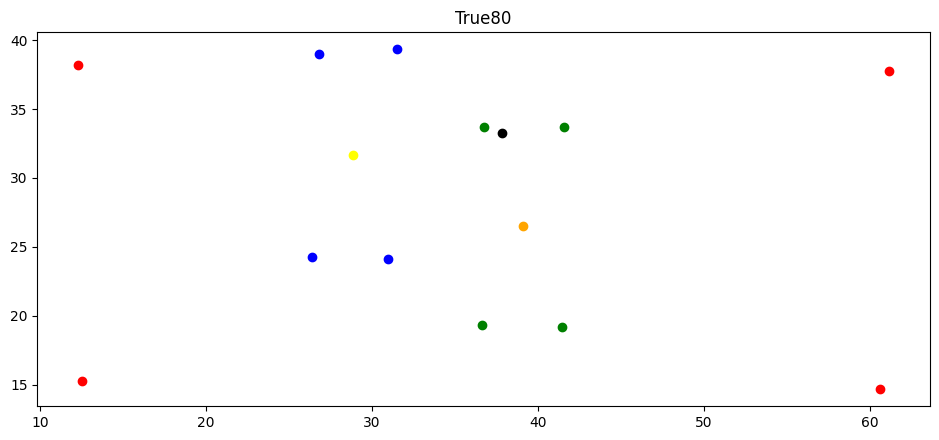

In [139]:
plt.figure(figsize=(9.5,4.5))
for ind, row in test.iterrows():
    plt.gca().set_title(str(row['odd'])+str(ind))

    plt.scatter([row['arenaTL_x_cm'] , row['arenaTR_x_cm'], row['arenaBL_x_cm'], row['arenaBR_x_cm']],
                [row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBL_y_cm'], row['arenaBR_y_cm']],color='red')

    plt.scatter([row['recen_obstacleTL_x_cm_fh'], row['recen_obstacleTR_x_cm_fh'], row['recen_obstacleBL_x_cm_fh'], row['recen_obstacleBR_x_cm_fh']],
                [row['recen_obstacleTL_y_cm_fh'], row['recen_obstacleTR_y_cm_fh'], row['recen_obstacleBL_y_cm_fh'], row['recen_obstacleBR_y_cm_fh']],color='blue')

    plt.scatter([row['recen_obstacleTL_x_cm_lh'], row['recen_obstacleTR_x_cm_lh'], row['recen_obstacleBL_x_cm_lh'], row['recen_obstacleBR_x_cm_lh']],
                [row['recen_obstacleTL_y_cm_lh'], row['recen_obstacleTR_y_cm_lh'], row['recen_obstacleBL_y_cm_lh'], row['recen_obstacleBR_y_cm_lh']],color='green')
    
    
    plt.scatter(row['recen_obstacle_cen_x_cm_fh'],row['recen_obstacle_cen_y_cm_fh'],color='yellow')
    plt.scatter(row['recen_obstacle_cen_x_cm_lh'],row['recen_obstacle_cen_y_cm_lh'],color='orange')

    plt.scatter(row['recen_arena_cen_x_cm'],row['recen_arena_cen_y_cm'], color ='black')

   
    #sns.scatterplot(x=row['nose_x_cm'],y=row['nose_y_cm'],hue = row['nose_x_cm'], palette ='magma')

    plt.tight_layout()            
                

In [130]:
columns_list


['arenaTL_x_cm',
 'arenaTL_y_cm',
 'arenaTR_x_cm',
 'arenaTR_y_cm',
 'arenaBL_x_cm',
 'arenaBL_y_cm',
 'arenaBR_x_cm',
 'arenaBR_y_cm',
 'arena_cen_x_cm',
 'arena_cen_y_cm',
 'obstacleTL_x_cm',
 'obstacleTL_y_cm',
 'obstacleTR_x_cm',
 'obstacleTR_y_cm',
 'obstacleBR_x_cm',
 'obstacleBR_y_cm',
 'obstacleBL_x_cm',
 'obstacleBL_y_cm',
 'obstacleTL_x_cm_fh',
 'obstacleTL_x_cm_lh',
 'obstacleTL_y_cm_fh',
 'obstacleTL_y_cm_lh',
 'obstacleTR_x_cm_fh',
 'obstacleTR_x_cm_lh',
 'obstacleTR_y_cm_fh',
 'obstacleTR_y_cm_lh',
 'obstacleBR_x_cm_fh',
 'obstacleBR_x_cm_lh',
 'obstacleBR_y_cm_fh',
 'obstacleBR_y_cm_lh',
 'obstacleBL_x_cm_fh',
 'obstacleBL_x_cm_lh',
 'obstacleBL_y_cm_fh',
 'obstacleBL_y_cm_lh',
 'obstacle_cen_x_cm_fh',
 'obstacle_cen_y_cm_fh',
 'obstacle_cen_x_cm_lh',
 'obstacle_cen_y_cm_lh']

In [76]:
columns

['obstacleTL_x_cm_fh',
 'obstacleTL_x_cm_lh',
 'obstacleTR_x_cm_fh',
 'obstacleTR_x_cm_lh',
 'obstacleBR_x_cm_fh',
 'obstacleBR_x_cm_lh',
 'obstacleBL_x_cm_fh',
 'obstacleBL_x_cm_lh',
 'obstacle_cen_x_cm_fh',
 'obstacle_cen_x_cm_lh',
 'obstacleTL_y_cm_fh',
 'obstacleTL_y_cm_lh',
 'obstacleTR_y_cm_fh',
 'obstacleTR_y_cm_lh',
 'obstacleBR_y_cm_fh',
 'obstacleBR_y_cm_lh',
 'obstacleBL_y_cm_fh',
 'obstacleBL_y_cm_lh',
 'obstacle_cen_y_cm_fh',
 'obstacle_cen_y_cm_lh']

In [75]:
stuff = [col for col in test.columns if 'recen_' in col]
stuff

['recen_obstacleTL_x_cm_fh',
 'recen_obstacleTL_x_cm_lh',
 'recen_obstacleTR_x_cm_fh',
 'recen_obstacleTR_x_cm_lh',
 'recen_obstacleBR_x_cm_fh',
 'recen_obstacleBR_x_cm_lh',
 'recen_obstacleBL_x_cm_fh',
 'recen_obstacleBL_x_cm_lh',
 'recen_obstacle_cen_x_cm_fh',
 'recen_obstacle_cen_x_cm_lh',
 'recen_obstacleTL_y_cm_fh',
 'recen_obstacleTL_y_cm_lh',
 'recen_obstacleTR_y_cm_fh',
 'recen_obstacleTR_y_cm_lh',
 'recen_obstacleBR_y_cm_fh',
 'recen_obstacleBR_y_cm_lh',
 'recen_obstacleBL_y_cm_fh',
 'recen_obstacleBL_y_cm_lh',
 'recen_obstacle_cen_y_cm_fh',
 'recen_obstacle_cen_y_cm_lh']

In [58]:
columns_x = [col for col in test.columns if 'x_cm_' in col]
columns_x = [col for col in columns_x if 'lind' not in col]
columns_y = [col for col in test.columns if 'y_cm_' in col]
columns_y = [col for col in columns_y if 'lind' not in col]
columns = columns_x +columns_y


In [59]:
columns

['obstacleTL_x_cm_fh',
 'obstacleTL_x_cm_lh',
 'obstacleTR_x_cm_fh',
 'obstacleTR_x_cm_lh',
 'obstacleBR_x_cm_fh',
 'obstacleBR_x_cm_lh',
 'obstacleBL_x_cm_fh',
 'obstacleBL_x_cm_lh',
 'obstacle_cen_x_cm_fh',
 'obstacle_cen_x_cm_lh',
 'obstacleTL_y_cm_fh',
 'obstacleTL_y_cm_lh',
 'obstacleTR_y_cm_fh',
 'obstacleTR_y_cm_lh',
 'obstacleBR_y_cm_fh',
 'obstacleBR_y_cm_lh',
 'obstacleBL_y_cm_fh',
 'obstacleBL_y_cm_lh',
 'obstacle_cen_y_cm_fh',
 'obstacle_cen_y_cm_lh']

In [113]:
## get center of arena
xvals = np.stack([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBL_x_cm'], row['arenaBR_x_cm']])
arena_cen_x = np.nanmedian(xvals)

yvals = np.stack([row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBL_y_cm'], row['arenaBR_y_cm']])
arena_cen_y = np.nanmedian(yvals)

In [ ]:
row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBL_y_cm'], row['arenaBR_y_cm']

In [15]:
def format_frames(vid_path,dwnsmpl):
    # open the .avi file
    vidread = cv2.VideoCapture(vid_path)
    # empty array that is the target shape
    # should be number of frames x downsampled height x downsampled width
    #all_frames = np.empty([int(vidread.get(cv2.CAP_PROP_FRAME_COUNT)),
                           #int(vidread.get(cv2.CAP_PROP_FRAME_HEIGHT)),
                           #int(vidread.get(cv2.CAP_PROP_FRAME_WIDTH))], dtype=np.uint8)
     
    all_frames = np.empty([int(vidread.get(cv2.CAP_PROP_FRAME_COUNT)),
                            int(vidread.get(cv2.CAP_PROP_FRAME_HEIGHT)*dwnsmpl),
                            int(vidread.get(cv2.CAP_PROP_FRAME_WIDTH)*dwnsmpl)], dtype=np.uint8)
    # iterate through each frame
    for frame_num in tqdm(range(0,int(vidread.get(cv2.CAP_PROP_FRAME_COUNT)))):
        # read the frame in and make sure it is read in correctly
        ret, frame = vidread.read()
        if not ret:
            break
        # convert to grayyscale
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # downsample the frame by an amount specified in the config file
        sframe = cv2.resize(frame, (0,0), fx=dwnsmpl, fy=dwnsmpl, interpolation=cv2.INTER_NEAREST) 

        # add the downsampled frame to all_frames as int8
        all_frames[frame_num,:,:] = sframe.astype(np.uint8)
    #if not usexr:
        #return all_frames    
          
        # store the combined video frames in an xarray

    formatted_frames = xr.DataArray(all_frames.astype(np.uint8), dims=['frame', 'height', 'width'])
        # label frame numbers in the xarray
    formatted_frames.assign_coords({'frame':range(0,len(formatted_frames))})
        # delete all frames, since it's somewhat large in memory
    del all_frames
    return formatted_frames

In [45]:
def plot_traces():

SyntaxError: invalid syntax (803721154.py, line 1)

In [ ]:
def check_likellihood():

In [18]:
vid = format_frames(r'C:/Users/nlab/obstacle_avoidance/recordings\101422\J20RT\oa\101422_J20RT_control_Rig2_oa_top1.avi',.75)

100%|██████████| 31413/31413 [00:36<00:00, 852.84it/s]


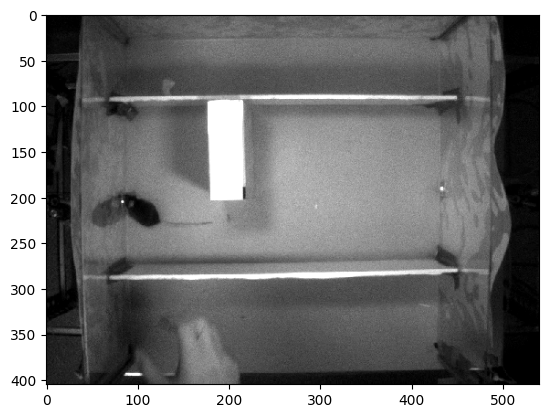

In [33]:
frame = vid[1000,:,:]
plt.imshow(frame, cmap='gray')

In [34]:
vid_save= vid.astype('int64')

MemoryError: Unable to allocate 51.2 GiB for an array with shape (31413, 405, 540) and data type int64

In [32]:
vid_save.to_netcdf(r'C:/Users/nlab/obstacle_avoidance/recordings\101422\J20RT\oa\frames.nc',mode='w', engine = 'netcdf4')

ImportError: DLL load failed while importing _netCDF4: The specified procedure could not be found.

In [27]:
vid.to_netcdf(r'C:/Users/nlab/obstacle_avoidance/recordings\101422\J20RT\oa\fames.nc', mode='w')

ValueError: could not safely cast array from dtype uint8 to int8

In [10]:
frames = vid[0:1000,:,:]

In [23]:
frames.shape

(1000, 540, 720)

In [27]:

np.array(df.at[1,'trial_vidframes'])

array([[1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925,
        1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936,
        1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947,
        1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958,
        1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
        1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
        1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
        1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
        2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
        2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024,
        2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035,
        2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046,
        2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057,
        2058, 2059, 2060, 2061, 2062, 

In [33]:
df.at[1,'trial_vidframes'].astype(int)[:,-1]

array([2157])

In [34]:
df.at[1,'trial_vidframes'].astype(int)[:,0]

array([1915])

In [52]:

for ind,row in df.iterrows():
    first_frame = row['trial_vidframes'][0]
    last_frame = row['trial_vidframes'][-1]
    df.at[ind,'trial_frames_array'] = vid[first_frame[0]:last_frame[-1],:,:].astype(object)

AttributeError: 'DataArray' object has no attribute 'take'

In [45]:
vid[first_frame[0]:last_frame[-1],:,:].astype(object).shape


(242, 540, 720)

In [33]:
row['trial_vidframes'][0]

2158

In [9]:
vid[first_frame:last_frame,:,:]

TypeError: only integer scalar arrays can be converted to a scalar index

In [14]:
first_frame[0]

1915

In [47]:
vid[first_frame[0]:last_frame[-1],:,:].shape

(242, 540, 720)

In [46]:
vid[first_frame[0]:last_frame[-1],:,:].astype(object)

array([[[0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [15, 10, 12, ..., 0, 0, 0],
        [13, 11, 12, ..., 0, 0, 0],
        [13, 12, 12, ..., 0, 0, 0]],

       [[1, 0, 0, ..., 0, 0, 0],
        [0, 0, 3, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [13, 12, 10, ..., 0, 0, 0],
        [12, 11, 10, ..., 0, 0, 0],
        [11, 11, 11, ..., 0, 0, 0]],

       [[0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [11, 9, 5, ..., 0, 0, 0],
        [11, 9, 6, ..., 0, 0, 0],
        [15, 12, 11, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [2, 0, 0, ..., 0, 0, 0],
        ...,
        [19, 18, 22, ..., 0, 0, 0],
        [15, 17, 17, ..., 0, 0, 0],
        [11, 16, 12, ..., 0, 0, 0]],

       [[2, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 2, ..., 0, 0, 0],
    